In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

## Machine Learning: Programming Exercise 3

## Multi-class Classification and Neural Networks
In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize hand-written digits.

In [2]:
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn import linear_model

## 1. Multi-class Classification

### 1.1 Dataset

 There are 5000 training examples in ex3data1.mat, where each training example is a 20 pixel by 20 pixel grayscale  image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that  location. The 20 by 20 grid of pixels is 'unrolled' into a 400-dimensional vector. Each of these training examples  becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example  for a handwritten digit image.

In [3]:
mat = scipy.io.loadmat('ex3data1.mat')

In [4]:
X = mat['X']
y = mat['y']

In [5]:
X.shape

(5000, 400)

### 1.2 Visualizing the data

(-0.5, 19.5, 19.5, -0.5)

(-0.5, 19.5, 19.5, -0.5)

(-0.5, 19.5, 19.5, -0.5)

(-0.5, 19.5, 19.5, -0.5)

(-0.5, 19.5, 19.5, -0.5)

(-0.5, 19.5, 19.5, -0.5)

(-0.5, 19.5, 19.5, -0.5)

(-0.5, 19.5, 19.5, -0.5)

(-0.5, 19.5, 19.5, -0.5)

(-0.5, 19.5, 19.5, -0.5)

(-0.5, 19.5, 19.5, -0.5)

(-0.5, 19.5, 19.5, -0.5)

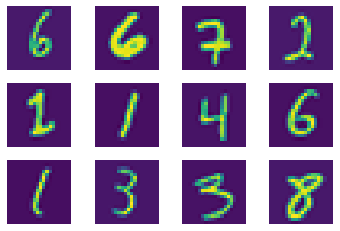

In [6]:
example_nums = 12
idxs = np.random.choice(range(X.shape[0]), example_nums, replace=False)
size = round(math.sqrt(X.shape[1]))

for i, idx in enumerate(idxs):
    plt.subplot(3, 4, i+1)
    plt.imshow(X[idx].reshape(size, size).T.astype('float'))
    plt.axis('off')
plt.show()
plt.close()

### 1.3 Vectorizing logistic regression
You will be using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers. To make this training efficient, it is important to ensure that your code is well vectorized. In this section, you will implement a vectorized version of logistic regression that does not employ any for loops. You can use your code in the last exercise as a starting point for this exercise.
#### 1.3.1 Vectorizing the cost function
We will begin by writing a vectorized version of the cost function. Recall that in (unregularized) logistic regression, the cost function is

<center>  $ J(\theta)=\frac{1}{m}\sum_{i=1}^m{\left[-y^{(i)}\log(h_{\theta}(x^{(i)}))-(1-y^{(i)})\log(1- h_{\theta}(x^{(i)}))\right]}$ </center> 

#### 1.3.2 Vectorizing the gradient

Recall that the gradient of the (unregularized) logistic regression cost is a vector where the th element is defined as 
<center>  $ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m}\sum_{i=1}^m{\left( h_\theta(x^{(i)})-y^{(i)}\right)x_j^{(i)}} $ </center> 

To vectorize this operation over the dataset, we start by writing out all the partial derivatives explicitly for all $\theta_j$, 

<center>  $ \left[ \begin{array}{c} 
\frac{\partial J(\theta)}{\partial \theta_0} \\
\frac{\partial J(\theta)}{\partial \theta_1} \\
\frac{\partial J(\theta)}{\partial \theta_2} \\
\vdots \\
\frac{\partial J(\theta)}{\partial \theta_n}   
 \end{array} \right] = \frac{1}{m} \left[ \begin{array}{c} 
\sum_{i=1}^m{\left( h_\theta(x^{(i)})-y^{(i)}\right)}x_0^{(i)} \\
\sum_{i=1}^m{\left( h_\theta(x^{(i)})-y^{(i)}\right)}x_1^{(i)} \\
\sum_{i=1}^m{\left( h_\theta(x^{(i)})-y^{(i)}\right)}x_2^{(i)} \\
\vdots \\
\sum_{i=1}^m{\left( h_\theta(x^{(i)})-y^{(i)}\right)}x_n^{(i)}
\end{array} \right]
=\frac{1}{m} \sum_{i=1}^m{ \left( h_\theta(x^{(i)})-y^{(i)}\right)} x^{(i)} =
\frac{1}{m}X^T {\left( h_\theta(x)-y\right)} $ </center> 

#### 1.3.3 Vectorizing regularized logistic regression

After you have implemented vectorization for logistic regression, you will now add regularization to the cost function. Recall that for regularized logistic regression, the cost function is defined as 

<center>$ J(\theta) =\frac{1}{m}\sum_{i=1}^m{\left[-y^{(i)} \log(h_{\theta}(x^{(i)}))- (1 -y^{(i)}) \log(1-h_{\theta}(x^{(i)})) \right]}+\frac{\lambda}{2m}\sum_{j=1}^n{\theta_j^2}$ </center> 

Note that you should not be regularizing $\theta_0$ which is used for the bias term. Correspondingly, the partial derivative of regularized logistic regression cost for $\theta_j$  is defined as 

<center> $\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m}\sum_{i=1}^m{\left( h_\theta(x^{(i)})-y^{(i)}\right)}x_j^{(i)}\qquad \mathrm{for}\;j=0, $ </center>

<center> $ \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m}\sum_{i=1}^m{\left( h_\theta(x^{(i)})-y^{(i)}\right)x_j^{(i)}} \right)+\frac{\lambda}{m}\theta_j\qquad \mathrm{for}\;j\geq1 $ </center>

In [7]:
def sigmoid(z):
    return 1./(1.+np.exp(-1.*z))

def lrCostFunction(theta, X, y, reg):
    m = len(y)
    h_theta = sigmoid(np.dot(X,theta))
    J = -(np.dot(y.T, np.log(h_theta))+np.dot((1-y.T), np.log(1-h_theta)))/m + reg*np.sum(theta[1:]**2)/(2*m)
    return J

def lrGradient(theta, X, y, reg):
    m = len(y)
    h_theta = sigmoid(np.dot(X,theta))
    temp = theta.copy()
    temp[0] = 0
    grad = (1/m)*np.dot(X.T, (h_theta - y)) + reg*temp/m
    return grad

In [8]:
theta_t = np.array([[-2., -1., 1., 2.]]).T
X_t = np.concatenate((np.ones((5,1)), np.array(range(1, 16)).reshape(3, 5).T/10.), axis=1)
y_t = np.array([[1, 0, 1, 0, 1]]).T
lambda_t = 3
J = lrCostFunction(theta_t, X_t, y_t, lambda_t)
grad = lrGradient(theta_t, X_t, y_t, lambda_t)

print('Cost: %f | Expected cost: 2.534819'%J)
print('Gradients: ', grad) 

Cost: 2.534819 | Expected cost: 2.534819
Gradients:  [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]


### 1.4 One-vs-all classication

In [9]:
def oneVsAll(X, y, labels, reg):
    m = X.shape[0]
    n = X.shape[1]
    num_labels = len(labels)
    X = np.concatenate((np.ones((m,1)), X), axis=1)
    all_theta = np.zeros((n+1, num_labels))
    initial_theta = np.zeros((n+1, 1))
    skl_lg_l2 = linear_model.LogisticRegression(C = 1.0 /reg, fit_intercept = False, solver = 'lbfgs')
    for c in range(num_labels):
        all_theta[:, c] = skl_lg_l2.fit(X, y ==c+1).coef_
    return all_theta

In [10]:
labels = np.array(range(1, 11))
reg = 0.1
all_theta = oneVsAll(X, y, labels, reg)

In [11]:
all_theta.shape

(401, 10)

#### 1.4.1 One-vs-all prediction

In [12]:
def predictOneVsAll(all_theta, X):
    m = X.shape[0]
    X = np.concatenate((np.ones((m,1)), X), axis=1)
    y_prob = sigmoid(np.dot(X,all_theta))
    y_pred = labels[np.argmax(y_prob, axis=1)]
    return y_pred

In [13]:
pred = predictOneVsAll(all_theta, X);
print('Training Set Accuracy: ', np.mean(pred == y.T) * 100)

Training Set Accuracy:  96.48


## 2. Neural Networks
Our neural networks has 3 layers- an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20 x 20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables X and y. 

You have been provided with a set of network parameters $(\Theta^{(1)},\Theta^{(2)})$ already trained by us. These are stored in ex3weights.mat and are loaded into Theta1 and Theta2 by running the code below. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [14]:
weights = scipy.io.loadmat('ex3weights.mat')

In [15]:
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']

In [16]:
Theta1.shape
Theta2.shape

(25, 401)

(10, 26)

In [17]:
def predict(Theta1, Theta2, X):
    m = X.shape[0]
    X = np.concatenate((np.ones((m,1)), X), axis=1)
    t1 = sigmoid(np.dot(X, Theta1.T))
    t1 = np.concatenate((np.ones((m,1)), t1), axis=1)

    y_prob = sigmoid(np.dot(t1, Theta2.T))
    y_pred = labels[np.argmax(y_prob, axis=1)]
    return y_pred

In [18]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: ', np.mean((pred == y.T)) * 100)

Training Set Accuracy:  97.52


In [20]:
#  Randomly permute examples
rp = np.random.choice(range(X.shape[0]), 1, replace=False)
#  Predict
pred = predict(Theta1, Theta2, X[rp,:]);
print('Neural Network Prediction: ', pred)

Neural Network Prediction:  [4]


(-0.5, 19.5, 19.5, -0.5)

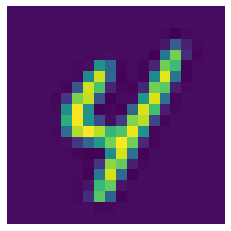

In [21]:
plt.imshow(X[rp,:].reshape(size, size).T.astype('float'))
plt.axis('off')